## Quantization aware (QKeras)Deep MLP for Jet-Images using jet constituents in HLS data
## Author: Andre Sznajder

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'
#data_dir = '/Users/sznajder/cernbox/WorkM1/tensorflow_macos/arm64/workdir/data/hls4ml_LHCjet_30p_val/'

import tensorflow as tf
print(f"TensorFlow {tf.__version__}")
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"Number of available GPUs : {len(gpus)}")
    tf.config.set_visible_devices(gpus[0],"GPU")
    tf.config.experimental.set_memory_growth(gpus[0],True)
else:
    print("No GPU available, using CPU !!!")    

    
# To disable GPU use
tf.config.set_visible_devices([], 'GPU')


TensorFlow 2.8.0
Number of available GPUs : 1


# Load train and test JetID datasets as numpy arrays 

In [3]:
import numpy as np
import h5py
import os
from einops import rearrange, reduce, repeat


#Data PATH
DATA_PATH = '/Users/sznajder/WorkM1/workdir/data/'

nconstit = 32

X_train_val = np.load("../../data/X_train_val_nconst_{}.npy".format(nconstit))
X_test = np.load("../../data/X_test_nconst_{}.npy".format(nconstit))
Y_train_val = np.load("../../data/Y_train_val_nconst_{}.npy".format(nconstit))
Y_test = np.load("../../data/Y_test_nconst_{}.npy".format(nconstit))

print("Loaded X_train_val ----> shape:", X_train_val.shape)
print("Loaded X_test      ----> shape:", X_test.shape)
print("Loaded Y_train_val ----> shape:", X_train_val.shape)
print("Loaded Y_test      ----> shape:", X_test.shape)

nfeat = X_train_val.shape[-1]

# Flatten the 2D into 1D arrays to input into a MLP 
X_train_val = rearrange( X_train_val , 'batch nconstit nfeat -> batch (nconstit nfeat)' )  
X_test      = rearrange( X_test , 'batch nconstit nfeat -> batch (nconstit nfeat)'      )  

print("Flattened X_train_val ----> shape:", X_train_val.shape)
print("Flattened X_test      ----> shape:", X_test.shape)



Loaded X_train_val ----> shape: (589600, 32, 3)
Loaded X_test      ----> shape: (290400, 32, 3)
Loaded Y_train_val ----> shape: (589600, 32, 3)
Loaded Y_test      ----> shape: (290400, 32, 3)
Flattened X_train_val ----> shape: (589600, 96)
Flattened X_test      ----> shape: (290400, 96)


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



## Define our Deep MLP model


In [4]:
# baseline keras model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras import utils

##################################
# Define execution ( CPU , GPU , any) 
# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
#from tensorflow.python.compiler.mlcompute import mlcompute
# Select CPU device.
#mlcompute.set_mlc_device(device_name='cpu') # Available options are 'cpu', 'gpu', and 'any'.

print('tensorflow version:',tf.__version__)
print('TF exceuting eagerly: ',tf.executing_eagerly())

##############################




#from qkeras.qlayers import QDense, QActivation , QBatchNormalization
#from qkeras.quantizers import quantized_bits, quantized_relu    
from qkeras import *


print("X type=",type(X_train_val))
print("X shape=",X_train_val.shape)

# Define MLP input layer dimension ( NINPUT = neta*nphi )
NINPUT = len(X_train_val[1])
NOUTPUT = len(Y_train_val[1])


print("NINPUT = ",NINPUT)
print("NOUTPUT = ",NOUTPUT)

#'''
# MLP architechture for 32 contituents
#scale=3.3
scale=3.0
nhidden1 = int(NINPUT/scale)
nhidden2 = int(NINPUT/scale)
nhidden3 = int(NINPUT/scale)
#'''

'''
# MLP architechture for 16 contituents
scale=0.8
nhidden1 = int(NINPUT*scale)
nhidden2 = int(NINPUT*scale)
nhidden3 = int(NINPUT*scale)
'''

'''
# MLP architechture for 8 contituents
scale=1.75
nhidden1 = int(NINPUT*scale) 
nhidden2 = int(NINPUT*scale) 
nhidden3 = int(NINPUT*scale) 
'''


#############################################################################


# Quantized bits
nbits=6
integ=0

#qbits = quantized_bits(nbits,integ,alpha=1.0)
#qact = 'quantized_relu('+str(nbits)+',0)'

# Set QKeras quantizer and activation 
if nbits == 1:
    qbits = 'binary(alpha=1)'
elif nbits == 2:
    qbits = 'ternary(alpha=1)'
else:
    qbits = 'quantized_bits({},0,alpha=1)'.format(nbits)

qact = 'quantized_relu({},0)'.format(nbits)



# Print
print("Trainign with max # of contituents = ", nconstit)
print("Number of node features = ", nfeat)
print("Quantization with nbits=",nbits)
print("Quantization of integer part=",integ)


#############################################################################



# Define the input tensor shape
inp  = Input(shape=(NINPUT,), name = 'inp') 

# Instantiate the MLP architechture 
h = BatchNormalization(name='batchnorm')(inp)

h = QDense( nhidden1, name = 'hidden1', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
h = QActivation( activation = qact, name = 'activation1')(h)

h = QDense( nhidden2, name = 'hidden2', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
h = QActivation( activation = qact, name = 'activation2')(h)

h = QDense( nhidden3, name='hidden3', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
h = QActivation( activation = qact, name = 'activation_dense3')(h)

out = QDense(NOUTPUT, name = 'denseout', kernel_quantizer=qbits, bias_quantizer=qbits )(h)
out= Activation("softmax",name = 'activationOut')(out)


# create the model
model = Model(inputs=inp, outputs=out)
# Define the optimizer ( minimization algorithm )
#optim = SGD(lr=0.01,decay=1e-6)
optim = Adam(learning_rate=0.0002)
#optim = Adam(learning_rate=0.0005)
#optim = Adam()

# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


# print the model summary
model.summary()

tensorflow version: 2.8.0
TF exceuting eagerly:  True
X type= <class 'numpy.ndarray'>
X shape= (589600, 96)
NINPUT =  96
NOUTPUT =  5
Trainign with max # of contituents =  32
Number of node features =  3
Quantization with nbits= 6
Quantization of integer part= 0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp (InputLayer)            [(None, 96)]              0         
                                                                 
 batchnorm (BatchNormalizati  (None, 96)               384       
 on)                                                             
                                                                 
 hidden1 (QDense)            (None, 32)                3104      
                                                                 
 activation1 (QActivation)   (None, 32)                0         
                                                              

##### Run training
Here, we run the training.

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

# Set model and output name
arch = 'QMLP'
fname = arch+'_nconst_'+str(nconstit)+'_nbits_'+str(nbits)
print('Model name : ',fname)


# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('model_'+fname+'.h5', monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq='epoch')

# Train classifier
history = model.fit( X_train_val , Y_train_val, 
                    epochs=200, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls,chkp], 
                    validation_split=0.3 )   



Model name :  QMLP_nconst_32_nbits_6
Epoch 1/200


2023-10-20 07:08:20.327819: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


791/807 [============================>.] - ETA: 0s - loss: 1.6253 - categorical_accuracy: 0.2150
Epoch 1: val_loss improved from inf to 1.59924, saving model to model_QMLP_nconst_32_nbits_6.h5
807/807 [==============================] - 2s 2ms/step - loss: 1.6248 - categorical_accuracy: 0.2155 - val_loss: 1.5992 - val_categorical_accuracy: 0.2420 - lr: 2.0000e-04
Epoch 2/200
803/807 [============================>.] - ETA: 0s - loss: 1.5776 - categorical_accuracy: 0.2728
Epoch 2: val_loss improved from 1.59924 to 1.54800, saving model to model_QMLP_nconst_32_nbits_6.h5
807/807 [==============================] - 1s 1ms/step - loss: 1.5774 - categorical_accuracy: 0.2730 - val_loss: 1.5480 - val_categorical_accuracy: 0.3029 - lr: 2.0000e-04
Epoch 3/200
775/807 [===========================>..] - ETA: 0s - loss: 1.5112 - categorical_accuracy: 0.3271
Epoch 3: val_loss improved from 1.54800 to 1.47439, saving model to model_QMLP_nconst_32_nbits_6.h5
807/807 [==============================] - 1s

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

N[0], N[1], label =  231937  ,  58463  ,  gluon
TP, label =  [0.0000e+00 1.0000e+00 1.0000e+00 ... 5.8462e+04 5.8463e+04 5.8463e+04]  ,  gluon
FP, label =  [0.00000e+00 0.00000e+00 1.00000e+00 ... 2.31877e+05 2.31877e+05
 2.31937e+05]  ,  gluon
TN, label =  [2.31937e+05 2.31937e+05 2.31936e+05 ... 6.00000e+01 6.00000e+01
 0.00000e+00]  ,  gluon
FN, label =  [5.8463e+04 5.8462e+04 5.8462e+04 ... 1.0000e+00 0.0000e+00 0.0000e+00]  ,  gluon
N[0], N[1], label =  233896  ,  56504  ,  quark
TP, label =  [0.0000e+00 1.0000e+00 1.0000e+00 ... 5.6503e+04 5.6504e+04 5.6504e+04]  ,  quark
FP, label =  [0.00000e+00 0.00000e+00 1.00000e+00 ... 2.33887e+05 2.33887e+05
 2.33896e+05]  ,  quark
TN, label =  [2.33896e+05 2.33896e+05 2.33895e+05 ... 9.00000e+00 9.00000e+00
 0.00000e+00]  ,  quark
FN, label =  [5.6504e+04 5.6503e+04 5.6503e+04 ... 1.0000e+00 0.0000e+00 0.0000e+00]  ,  quark
N[0], N[1], label =  232073  ,  58327  ,  W
TP, label =  [0.0000e+00 0.0000e+00 1.0000e+00 ... 5.8326e+04 5.8327e+04

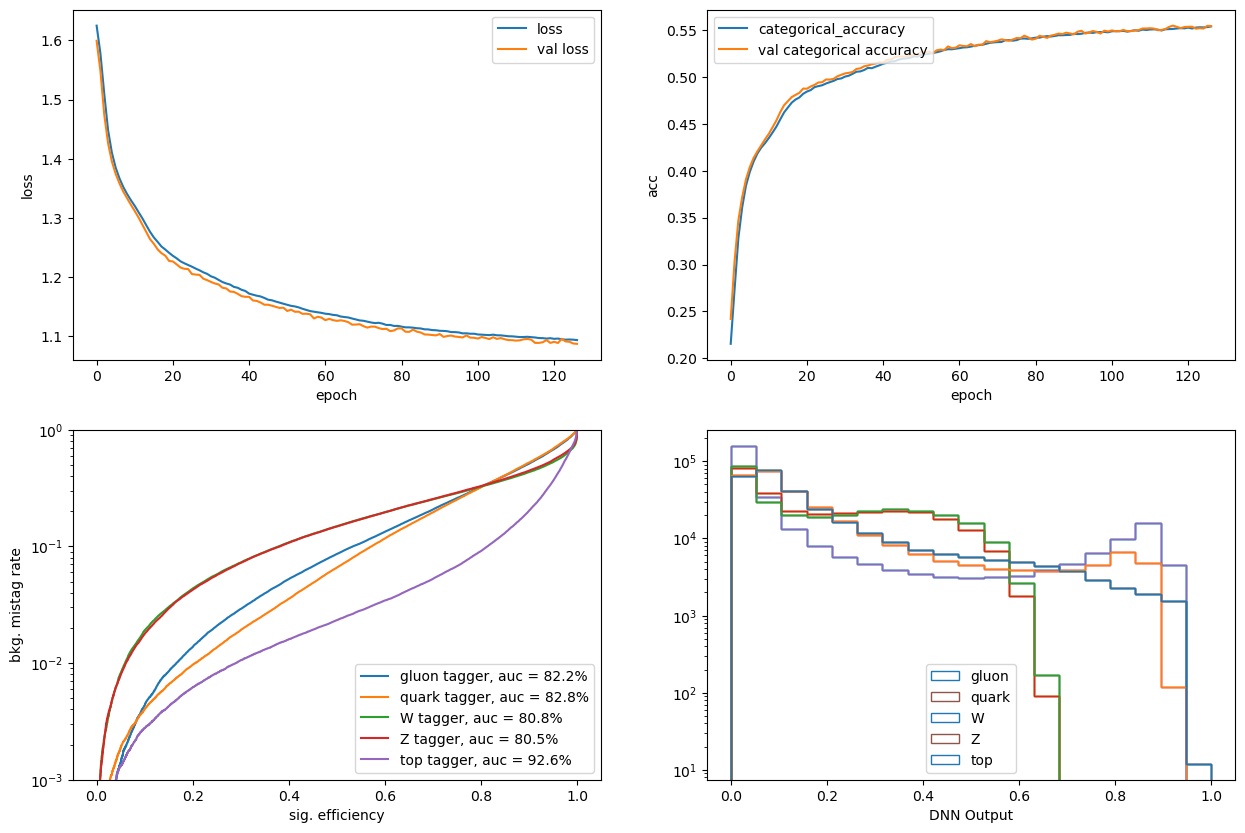

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}

# Model Prediction
Y_predict = model.predict(X_test)

# Loop over classes(labels) to get metrics per class and plots
ax = plt.subplot(2, 2, 3)
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
#    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    print('N[0], N[1], label = ', N[0], ' , ', N[1], ' , ' , label)
    
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    print('TP, label = ', TP[label], ' , ' , label)
    print('FP, label = ', FP[label], ' , ' , label)
    print('TN, label = ', TN[label], ' , ' , label)
    print('FN, label = ', FN[label], ' , ' , label)

    
    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))

   
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(loc='lower left')
ax.legend(prop={'size': 10})

# Display plots
fig = plt.gcf()
plt.show()


## Save information

In [7]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)


# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))

with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)



'''
# Save confusion matrix ndarrays to .npz file
with open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:
    vars = {}
    vars[arch]=np.array(1) # save model name
    for label in labels:
        vars['tresholds_'+label+'_'+arch] = tresholds[label]
        vars['TP_'+label+'_'+arch] = TP[label]
        vars['FP_'+label+'_'+arch] = FP[label]
        vars['TN_'+label+'_'+arch] = TN[label]
        vars['FN_'+label+'_'+arch] = FN[label]
        vars['TPR_'+arch] = tpr[label]
        vars['FPR_'+arch] = fpr[label]
        vars['NP_'+arch]= NP[label]
        vars['NN_'+arch]= NN[label]
        vars['auc_'+arch] = auc1[label] 
#        print(vars)
    np.savez(file, **vars)
'''


Label =  gluon  with treshold =  0.3
TPR =  0.30013854916784977
FPR =  0.02911997654535499
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000940765954536
FPR =  0.08610096707295516
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000102629013222
FPR =  0.3238163811724736
 
Label =  quark  with treshold =  0.3
TPR =  0.3000141582896786
FPR =  0.019175188972876834
 
Label =  quark  with treshold =  0.5
TPR =  0.5000353957241965
FPR =  0.06574289427779868
 
Label =  quark  with treshold =  0.8
TPR =  0.8000141582896786
FPR =  0.32059120292779697
 
Label =  W  with treshold =  0.3
TPR =  0.30003257496528196
FPR =  0.07271418906981855
 
Label =  W  with treshold =  0.5
TPR =  0.5000257170778541
FPR =  0.14856532211847134
 
Label =  W  with treshold =  0.8
TPR =  0.8000068578874278
FPR =  0.32568631422009453
 
Label =  Z  with treshold =  0.3
TPR =  0.3000154276016936
FPR =  0.07223469488888794
 
Label =  Z  with treshold =  0.5
TPR =  0.5000085708898298
FPR =  0.14822268090992533
 
Label 

"\n# Save confusion matrix ndarrays to .npz file\nwith open('CONF_MATRIX_'+fname+'.npz', 'wb') as file:\n    vars = {}\n    vars[arch]=np.array(1) # save model name\n    for label in labels:\n        vars['tresholds_'+label+'_'+arch] = tresholds[label]\n        vars['TP_'+label+'_'+arch] = TP[label]\n        vars['FP_'+label+'_'+arch] = FP[label]\n        vars['TN_'+label+'_'+arch] = TN[label]\n        vars['FN_'+label+'_'+arch] = FN[label]\n        vars['TPR_'+arch] = tpr[label]\n        vars['FPR_'+arch] = fpr[label]\n        vars['NP_'+arch]= NP[label]\n        vars['NN_'+arch]= NN[label]\n        vars['auc_'+arch] = auc1[label] \n#        print(vars)\n    np.savez(file, **vars)\n"

In [8]:
from sklearn.metrics import accuracy_score

# Save a sample of events for Thea test on HLS

njets=3000
print(X_test.shape)
np.save('x_test_'+str(nconstit)+'const_QMLP.npy', X_test[0:njets,:])
np.save('y_test_'+str(nconstit)+'const_QMLP.npy', Y_test[0:njets,:])

'''
print(X_test.shape)
np.save('x_test_'+str(nconstit)+'const_full_QMLP.npy', X_test)
np.save('y_test_'+str(nconstit)+'const_full_QMLP.npy', Y_test)
'''

# Keras average accuracy to compare with 
y_keras = model.predict(X_test[0:njets,:])
accuracy_keras  = float(accuracy_score (np.argmax(Y_test[0:njets,:],axis=1), np.argmax(y_keras,axis=1)))
print("accuracy_keras = ",accuracy_keras)


(290400, 96)
accuracy_keras =  0.5676666666666667
